# MPB ModeSolver

Now let's obtain the plot on the right (Figure from [3]) :

![alt text](http://www.simpetus.com/files/SOI_waveguide_bands.png)

In [1]:
# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

# for parsing text files


Start by defining the geometry from last time :

In [2]:
# Parameters for the waveguide
w = 0.3  # Si width (um)
h = 0.25  # Si height (um)

# Materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

sc_y = 2  # supercell width (um)
sc_z = 2  # supercell height (um)
resolution = 32  # pixels/um
geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z))

# define the 2d blocks for the strip and substrate
geometry = [mp.Block(size=mp.Vector3(mp.inf, mp.inf, 0.5 * (sc_z - h)),
                     center=mp.Vector3(z=0.25 * (sc_z + h)), material=SiO2),
            mp.Block(size=mp.Vector3(mp.inf, w, h), material=Si)]

### Defining the simulation

Now, instead of only initializing the geometry, we will load simulation parameters.

In [3]:
# The k (i.e. beta, i.e. propagation constant) points to look at, in
# units of 2*pi/um.  We'll look at num_k points from k_min to k_max.
num_k = 30
k_min = 0.1
k_max = 3.0
k_points = mp.interpolate(num_k, [mp.Vector3(k_min), mp.Vector3(k_max)])

# Increase this to see more modes.  (The guided ones are the ones below the
# light line, i.e. those with frequencies < kmag / 1.45, where kmag
# is the corresponding column in the output if you grep for "freqs:".)
num_bands = 4

In [4]:
# ModeSolver object
ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    # Add new things pertaining to simulation
    k_points=k_points,
    resolution=resolution,
    num_bands=num_bands,
    )

### Running the simulation

The simulation will be initialized as before when run() is called.

In [5]:
ms.run()

Initializing eigensolver data
Computing 4 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 1 x 64 x 64.
Solving for 4 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 2, 0)
     (0, 0, 2)
Cell volume = 4
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.5, -0)
     (0, -0, 0.5)
Geometric objects:
     block, center = (0,0,0.5625)
          size (1e+20,1e+20,0.875)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (1e+20,0.3,0.25)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 2 and 8 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
32 k-points
  Vector3<0.1, 0.0, 0.0>
  Vector3<0.1935483870967742, 0.0, 0.0>
  Vector3<0.2870967741935484, 0.0, 0.0>
  Vector3<0.38064516129032255, 0.0, 0.0>
  Vector3<0.4741935483870968, 0.0, 0.0>
  Vecto

It solved, great! We can see from the text output lines like :

`solve_kpoint (0.1,0,0):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 28 iterations.
freqs:, 1, 0.1, 0, 0, 0.1, 0.0807582, 0.0855765, 0.3147, 0.394675
elapsed time for k point: 0.14001059532165527`

This contains our band information. Unfortunately, MPB only keeps in memory one at a time. So we only have access to the last one :

In [6]:
print(ms.current_k)
print(ms.freqs)

Vector3<3.0, 0.0, 0.0>
[1.0814996959234677, 1.1042853219436242, 1.2769288155070349, 1.351049789287694]


So let's do it again, this time capturing the output :

In [7]:
%%capture --no-stderr output
ms.run()

In [8]:
output_text = output.stdout
output_text.split('\n')

['Initializing eigensolver data',
 'Computing 4 bands with 1e-07 tolerance',
 'Working in 3 dimensions.',
 'Grid size is 1 x 64 x 64.',
 'Solving for 4 bands at a time.',
 'Creating Maxwell data...',
 'Mesh size is 3.',
 'Lattice vectors:',
 '     (1, 0, 0)',
 '     (0, 2, 0)',
 '     (0, 0, 2)',
 'Cell volume = 4',
 'Reciprocal lattice vectors (/ 2 pi):',
 '     (1, -0, 0)',
 '     (-0, 0.5, -0)',
 '     (0, -0, 0.5)',
 'Geometric objects:',
 '     block, center = (0,0,0.5625)',
 '          size (1e+20,1e+20,0.875)',
 '          axes (1,0,0), (0,1,0), (0,0,1)',
 '     block, center = (0,0,0)',
 '          size (1e+20,0.3,0.25)',
 '          axes (1,0,0), (0,1,0), (0,0,1)',
 'Geometric object tree has depth 2 and 8 object nodes (vs. 2 actual objects)',
 'Initializing epsilon function...',
 'Solving for band polarization: .',
 'Initializing fields to random numbers...',
 '32 k-points',
 '  Vector3<0.1, 0.0, 0.0>',
 '  Vector3<0.1935483870967742, 0.0, 0.0>',
 '  Vector3<0.287096774193548

### Analyzing the results

Let's parse every line that begins with 'freqs :' in the output.

Notice the lines all have the same syntax `'freqs:, 22, 2, 0, 0, 2, 0.846477, 0.874081, 1.04852, 1.16543',`

i.e. for all the lines that start by 'freqs:' contains all the information we need in the form `freqs:, k index, kx, ky, kz, kmag/2pi, band 1, band 2, band 3, band 4, band 5, band 6, band 7, band 8 ...`. Python's `split` function and treating strings as arrays (slicing and indexing) is handy :

In [9]:
freqs = []
ks = []
line_header = "freqs:"
for ln in output_text.split('\n'):
    if ln.startswith(line_header):
        print(ln)
        line = ln.split(', ')
        print(line)
        ks.append([line[2], line[3], line[4]])
        freqs.append([line[-4], line[-3], line[-2], line[-1]])
        
freqs = np.array(freqs, dtype=np.float32)
ks = np.array(ks, dtype=np.float32)

freqs:, 1, 0.1, 0, 0, 0.1, 0.0807582, 0.0855765, 0.3147, 0.394675
['freqs:', '1', '0.1', '0', '0', '0.1', '0.0807582', '0.0855765', '0.3147', '0.394675']
freqs:, 2, 0.193548, 0, 0, 0.193548, 0.155365, 0.16422, 0.341458, 0.410987
['freqs:', '2', '0.193548', '0', '0', '0.193548', '0.155365', '0.16422', '0.341458', '0.410987']
freqs:, 3, 0.287097, 0, 0, 0.287097, 0.228276, 0.240091, 0.381337, 0.436147
['freqs:', '3', '0.287097', '0', '0', '0.287097', '0.228276', '0.240091', '0.381337', '0.436147']
freqs:, 4, 0.380645, 0, 0, 0.380645, 0.298937, 0.311941, 0.430273, 0.467754
['freqs:', '4', '0.380645', '0', '0', '0.380645', '0.298937', '0.311941', '0.430273', '0.467754']
freqs:, 5, 0.474194, 0, 0, 0.474194, 0.367072, 0.379151, 0.483705, 0.502991
['freqs:', '5', '0.474194', '0', '0', '0.474194', '0.367072', '0.379151', '0.483705', '0.502991']
freqs:, 6, 0.567742, 0, 0, 0.567742, 0.432542, 0.441894, 0.536768, 0.538894
['freqs:', '6', '0.567742', '0', '0', '0.567742', '0.432542', '0.441894', '0

In [10]:
print(freqs)
print(ks)

[[0.0807582 0.0855765 0.3147    0.394675 ]
 [0.155365  0.16422   0.341458  0.410987 ]
 [0.228276  0.240091  0.381337  0.436147 ]
 [0.298937  0.311941  0.430273  0.467754 ]
 [0.367072  0.379151  0.483705  0.502991 ]
 [0.432542  0.441894  0.536768  0.538894 ]
 [0.494782  0.500315  0.573355  0.58507  ]
 [0.551001  0.553305  0.608206  0.629108 ]
 [0.593884  0.598211  0.651795  0.674567 ]
 [0.622664  0.633694  0.706501  0.725007 ]
 [0.645081  0.662012  0.765683  0.779634 ]
 [0.665138  0.686152  0.824909  0.836268 ]
 [0.684281  0.708024  0.869466  0.892966 ]
 [0.703123  0.728677  0.894377  0.947171 ]
 [0.721964  0.748699  0.91638   0.994817 ]
 [0.740959  0.768431  0.937664  1.03361  ]
 [0.760193  0.788079  0.958655  1.06537  ]
 [0.779709  0.807772  0.979518  1.09248  ]
 [0.799526  0.827589  1.00034   1.11654  ]
 [0.81965   0.847578  1.02116   1.13857  ]
 [0.840077  0.867771  1.04203   1.15923  ]
 [0.8608    0.888182  1.06295   1.17897  ]
 [0.881807  0.908821  1.08394   1.19812  ]
 [0.903085 

We can now plot. Let's add the lightline too :

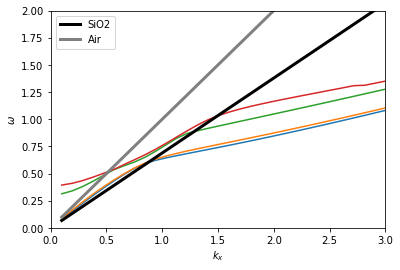

In [14]:
fig, ax = plt.subplots()

ax.plot(ks[:,0], freqs)
ax.plot(ks[:,0], ks[:,0]/1.45, 'k-', linewidth=3, label='SiO2')
ax.plot(ks[:,0], ks[:,0]/1, '-', color='gray', linewidth=3, label='Air')
ax.set_xlabel('$k_x$')
ax.set_ylabel('$\omega$')
ax.set_xlim([0,3])
ax.set_ylim([0,2])
ax.legend()

But wait! This doesn't look like above! It seems to be multimode at $\omega = 1/1.55 \approx 0.65 \rightarrow \lambda = 1.55\mu m$. What's wrong?

### Plotting field profiles

Let's look at the modes at a given frequency, say $1.55\mu$m. We can proceed inversely : `ms.run()` computes $\omega(k)$, while `ms.find_k` computes $k(\omega)$. Here, we will also pass a mpb function to the `run()` function, which will output h5 files.

In [57]:
%%capture --no-stderr output

f_mode = 1/1.55   # frequency corresponding to 1.55 um                                                                                                             
band_min = 1
band_max = 3
kdir = mp.Vector3(1)
tol = 1e-6
kmag_guess = f_mode*3.45
kmag_min = f_mode*0.1
kmag_max = f_mode*4.0

ms.find_k(mp.NO_PARITY, f_mode, band_min, band_max, kdir, tol, kmag_guess,
          kmag_min, kmag_max, mpb.output_poynting_x)
output_text = output.stdout

In [58]:
output_text = output.stdout
output_text.split('\n')

['Initializing fields to random numbers...',
 'Initializing eigensolver data',
 'Computing 3 bands with 1e-07 tolerance',
 'Working in 3 dimensions.',
 'Grid size is 1 x 64 x 64.',
 'Solving for 3 bands at a time.',
 'Creating Maxwell data...',
 'Mesh size is 3.',
 'Lattice vectors:',
 '     (1, 0, 0)',
 '     (0, 2, 0)',
 '     (0, 0, 2)',
 'Cell volume = 4',
 'Reciprocal lattice vectors (/ 2 pi):',
 '     (1, -0, 0)',
 '     (-0, 0.5, -0)',
 '     (0, -0, 0.5)',
 'Geometric objects:',
 '     block, center = (0,0,0.5625)',
 '          size (1e+20,1e+20,0.875)',
 '          axes (1,0,0), (0,1,0), (0,0,1)',
 '     block, center = (0,0,0)',
 '          size (1e+20,0.3,0.25)',
 '          axes (1,0,0), (0,1,0), (0,0,1)',
 'Geometric object tree has depth 2 and 8 object nodes (vs. 2 actual objects)',
 'Initializing epsilon function...',
 'Solving for band polarization: .',
 '1 k-points',
 '  Vector3<2.2258064516129035, 0.0, 0.0>',
 'elapsed time for initialization: 0.009303092956542969',
 

Let's look at the modes.